ConvLSTM trained on gridded forcings for all stations

In [19]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn import preprocessing
import netCDF4 as nc
import torch
from torch import nn, utils
from torch.utils.tensorboard import SummaryWriter
from src import load_data, evaluate, conv_lstm, datasets, visualize
import torch.autograd as autograd
import pickle
import matplotlib.pyplot as plt
import torchvision as tv

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'20190725-142127'

In [2]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='../log.out', mode='a')
chandler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('%(asctime)s - {} - %(message)s'.format(time_stamp))
fhandler.setFormatter(formatter)
chandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.addHandler(chandler)
logger.setLevel(logging.INFO)

In [3]:
USE_CUDA = False
if torch.cuda.is_available():
    print('CUDA Available')
    USE_CUDA = True
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
num_devices = torch.cuda.device_count() if USE_CUDA else 0
logger.warning('cuda devices: {}'.format(list(torch.cuda.get_device_name(i) for i in range(num_devices))))
torch.manual_seed(0)
np.random.seed(0)

2019-07-25 13:15:56,162 - 20190725-131556 - cuda devices: []


In [4]:
batch_size = 16
seq_len = 5*24
seq_steps = 2
stateful_lstm = False
validation_fraction, val_start, val_end = None, None, None

train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(hours=seq_len * seq_steps)  # first day for which to make a prediction in train set
train_end = '2012-12-31'
test_start = '2013-01-01'
test_end = '2014-12-31'

In [5]:
rdrs_vars = list(range(8))
train_dataset = datasets.RdrsGridDataset(rdrs_vars, seq_len, seq_steps, train_start, train_end)
test_dataset = datasets.RdrsGridDataset(rdrs_vars, seq_len, seq_steps, test_start, test_end, conv_scalers=train_dataset.conv_scalers)

In [6]:
rdrs_data, rdrs_varnames, _ = load_data.load_rdrs_forcings(as_grid=True)

In [7]:
rdrs_varnames = np.array(rdrs_varnames)[rdrs_vars]

In [8]:
class ConvLSTMGrid(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers, dropout=0.0):
        super(ConvLSTMGrid, self).__init__()
        self.conv_lstm = conv_lstm.ConvLSTM((input_size[0], input_size[1]), input_dim, hidden_dim, kernel_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout2d(p=dropout)
        self.conv_out = nn.Conv2d(hidden_dim[-1], 1, (1,1))
        
    def forward(self, input_tensor, hidden_state=None):
        convlstm_out, hidden = self.conv_lstm(input_tensor, hidden_state=hidden_state)
        convlstm_out = self.dropout(convlstm_out[-1][:,-1,:,:,:])  # last output of last layer
        return self.conv_out(convlstm_out)[:,0,:,:], hidden

In [9]:
model = torch.load('../pickle/models/ConvLSTM_VIC_allStations_20190724-140611.pkl', map_location='cpu').module

In [10]:
model

ConvLSTMGrid(
  (conv_lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (1): Identity()
      (2): ConvLSTMCell(
        (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (3): Identity()
    )
  )
  (dropout): Dropout2d(p=0.3)
  (conv_out): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [11]:
if stateful_lstm:
    test_sampler = datasets.StatefulBatchSampler(test_dataset, batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_sampler, pin_memory=True)
else:
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True, drop_last=True)

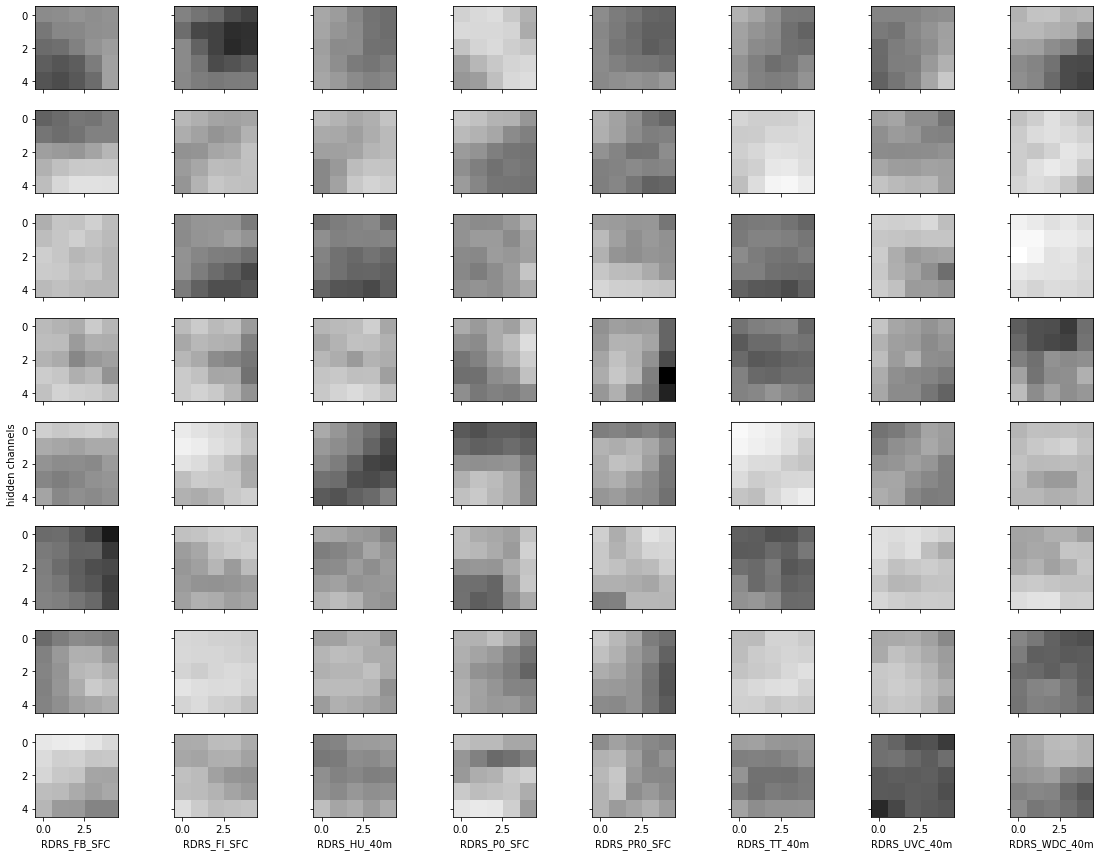

In [20]:
# Visualize kernel
convlstm_conv = model.conv_lstm.cell_list[0].conv
visualize.visualize_kernels(convlstm_conv, rdrs_varnames, convlstm_conv.weight.shape[0] // 4)

In [13]:
in_data = test_dataloader.__iter__().next()
x_conv, y, mask = in_data['x_conv'], in_data['y'], in_data['mask']
out, _ = model(x_conv, hidden_state=None)
out = out.detach()

In [14]:
sample = 0 # which sample of the batch to look at

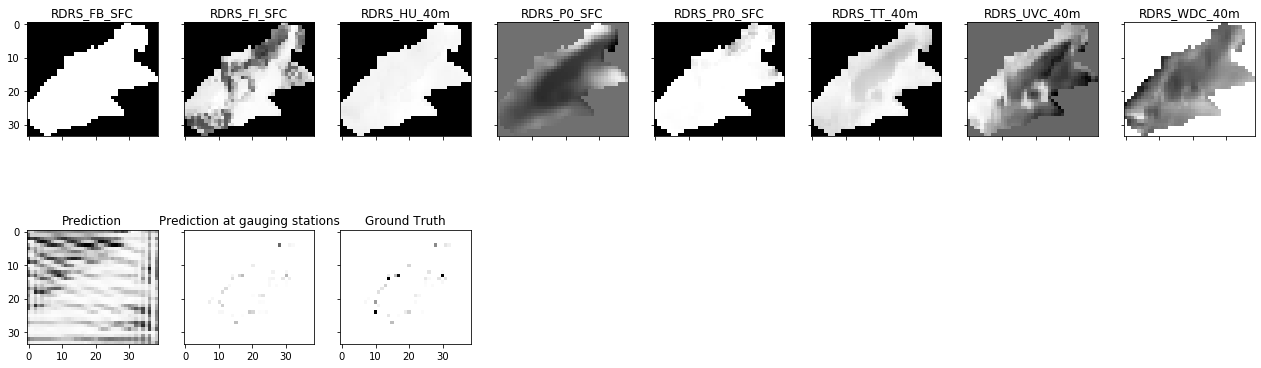

In [15]:
f, ax = plt.subplots(2,len(rdrs_varnames), sharex=True, sharey=True, figsize=(22,7))
for i in range(len(rdrs_varnames)):
    ax[0,i].imshow(x_conv[sample,-1,i], cmap='Greys')
    ax[0,i].set_title(rdrs_varnames[i])
ax[1,0].imshow(out[sample], cmap='Greys', vmin=out[sample].min(), vmax=out[sample].max())
ax[1,1].imshow(np.ma.masked_where(mask[sample] == 0,out[sample]), cmap='Greys', vmin=out[sample].min(), vmax=out[sample].max())
ax[1,2].imshow(np.ma.masked_where(mask[sample] == 0,y[sample]), cmap='Greys', vmin=out[sample].min(), vmax=out[sample].max())

_ = ax[1,0].set_title('Prediction')
_ = ax[1,1].set_title('Prediction at gauging stations')
_ = ax[1,2].set_title('Ground Truth')
_ = list(f.delaxes(ax[1,i]) for i in range(3,len(rdrs_varnames)))

In [16]:
model.conv_lstm.return_all_layers = True
layers_out, _ = model.conv_lstm(x_conv)

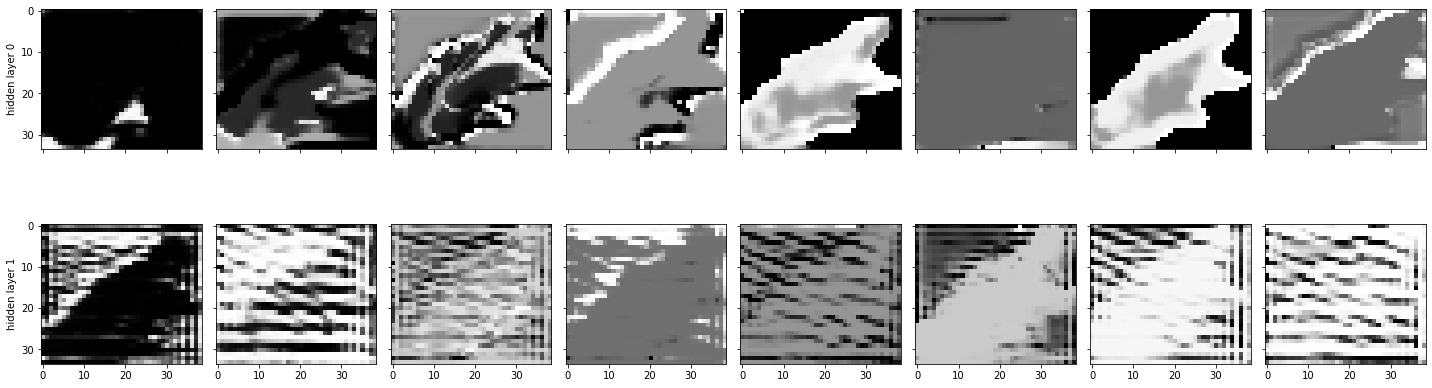

In [23]:
# Visualize conv_lstm hidden layer channels
visualize.visualize_hidden_channels(layers_out, sample, is_convlstm=True)